#### ResNet architecture
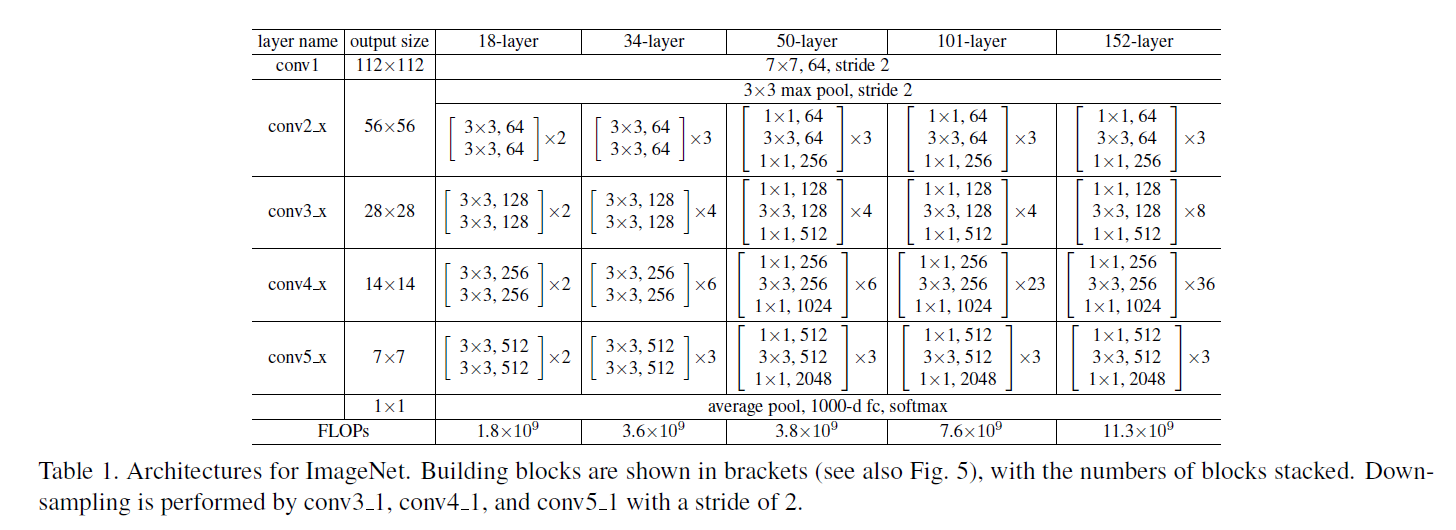

#### Bottleneck block:
In the ResNet50 architecture, the 1x1 convolutions in the bottleneck block serve several purposes:

**Dimensionality Reduction:** The first 1x1 convolution reduces the number of channels (features) of the input data, decreasing the computational cost and memory usage.

**Channel Expansion:** The second 1x1 convolution increases the number of channels, restoring the original dimensionality.

**Non-linearity:** The 1x1 convolutions introduce non-linearity, allowing the network to learn more complex features.

**Bottleneck Design:** The 1x1 convolutions create a bottleneck design, where the network is forced to learn a compact representation of the data, improving its ability to generalize.
    

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy

# Define the basic building block of ResNet (Residual Block). BasucBlock is used in ResNet18 and ResNet34
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the Bottleneck block used in ResNet50
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)  # 1x1 convolution
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)  # 3x3 convolution
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)  # 1x1 convolution
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the ResNet50 architecture
# The input image size is 224 * 224 * 3
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.in_channels = 64
        # Initial convolution layer with batch normalization and ReLU activation
        # n_out = (n+2p-f)/s + 1 where n = input image (square) dimension, n_out = output image dimension, f = kernel size
        # in = 224, out = 112
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        # out = (in - f + 2p)/s + 1 = (112 -3 + 2*1)/2 + 1 = 56
        # in = 112, out = 56
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Define the four layers of ResNet50, each layer consisting of multiple Bottleneck blocks
        # in = 56, out = 56, in_channels = 64, out_channels = 64       
        # for the layer1 there is no downsampling as stride = 1 and in_channels == out_channels (both are 64)
        self.layer1 = self._make_layer(block=Bottleneck, out_channels=64, blocks=3)
        # in = 56, out = 28, in_channels = 256, out_channels = 128
        # Only the first residual block in each layer (from second layer on) has downsampling
        self.layer2 = self._make_layer(block=Bottleneck, out_channels=128, blocks=4, stride=2)    #(28, 28, 512)
        # in = 28, out = 14, in_channels = 512, out_channels = 256
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)    #(14, 14, 1024)
        # in = 14, out = 7, in_channels = 1024, out_channels = 512
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)    #(7, 7, 2048)
        # in = 7, out = 1   (output image size = 1x1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))     #(1, 1, 2048)
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and max-pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Passing through each of the four layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Average pooling and fully connected layer for classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
# Define the Lightning module
class ResNet50LitModel(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super(ResNet50LitModel, self).__init__()
        self.save_hyperparameters()
        self.model = ResNet50(num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": val_loss, "val_acc": acc}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        self.log('avg_val_loss', avg_val_loss)
        self.log('avg_val_acc', avg_val_acc)

# Example usage
def main():
    # Instantiate the model
    model = ResNet50LitModel(num_classes=10, lr=1e-3)

    # Define your data loaders
    train_dataloader = ...  # Define your training dataloader here
    val_dataloader = ...  # Define your validation dataloader here

    # Set up PyTorch Lightning Trainer
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        log_every_n_steps=10
    )

    # Train the model
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

if __name__ == "__main__":
    main()
